## 1. Select L40 admission within 1 year to blood sampling

In [1]:
%%bash
dx download "UKB Metabolomics:/agarham/icd_med_dataset.tsv"
dx download "UKB Metabolomics:/agarham/participant_dataset.tsv"

In [2]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Import libraries
import pandas as pd
import numpy as np
import re

# Import the datasets
df = pd.read_csv('icd_med_dataset.tsv', sep='\t')
part_df = pd.read_csv('participant_dataset.tsv', sep='\t')

In [3]:
# Merge the date of attendance to the dataframe
df = pd.merge(part_df[['eid', '53-0.0', '131742-0.0']], df,
              how='inner', on='eid')

# Create list of date columns
date_cols = [column for column in df.columns if column.startswith('41262-0.')]

# Split the string by "|" and expand into separate columns
split_cols = df['41202-0.0'].str.split('|', expand=True)

# Rename columns to '41202-0.0', '41202-0.1', etc.
split_cols.columns = [f'41202-0.{i}' for i in range(split_cols.shape[1])]

# Return the splitted data to the original dataset
df[split_cols.columns] = split_cols

In [4]:
# Define psoriasis-related ICD codes
pso_codes = {'L40', 'L400', 'L401', 'L402', 'L403', 'L404', 'L405', 'L408', 'L409'}

# Convert 53-0.0 to datetime
df['53-0.0'] = pd.to_datetime(df['53-0.0'], errors='coerce')

# Get all 41202 and 41262 columns 
icd_cols = [col for col in df.columns if col.startswith('41202-0.')] 
date_cols = [col for col in df.columns if col.startswith('41262-0.')] 

# Melt ICD and date columns into long format
icd_long = df.melt(
    id_vars=['eid', '53-0.0'],
    value_vars=icd_cols,
    var_name='icd_col',
    value_name='icd_code'
)

dates_long = df.melt(
    id_vars=['eid'],
    value_vars=date_cols,
    var_name='date_col',
    value_name='icd_date'
)

# Check the melted df
icd_long.head()

,eid,53-0.0,icd_col,icd_code
0,3002526,2007-12-18,41202-0.0,H024
1,4316114,2009-08-08,41202-0.0,K409
2,6001478,2008-04-04,41202-0.0,I771
3,2550795,2009-11-20,41202-0.0,C61
4,2915507,2010-07-02,41202-0.0,A099


In [5]:
# Check the metled df
dates_long.head()

,eid,date_col,icd_date
0,3002526,41262-0.0,2012-08-20
1,4316114,41262-0.0,2010-09-11
2,6001478,41262-0.0,2020-03-03
3,2550795,41262-0.0,2021-08-31
4,2915507,41262-0.0,2014-06-25


In [6]:
# Extract suffix from column names (e.g., 41202-0.5 suffix=5)
icd_long['suffix'] = icd_long['icd_col'].str.extract(r'(\d+)$')
dates_long['suffix'] = dates_long['date_col'].str.extract(r'(\d+)$')

# Merge ICD codes with corresponding dates
merged = icd_long.merge(dates_long, on=['eid', 'suffix'], how='left')

# Check the merged df
merged.head()

,eid,53-0.0,icd_col,icd_code,suffix,date_col,icd_date
0,3002526,2007-12-18,41202-0.0,H024,0,41262-0.0,2012-08-20
1,4316114,2009-08-08,41202-0.0,K409,0,41262-0.0,2010-09-11
2,6001478,2008-04-04,41202-0.0,I771,0,41262-0.0,2020-03-03
3,2550795,2009-11-20,41202-0.0,C61,0,41262-0.0,2021-08-31
4,2915507,2010-07-02,41202-0.0,A099,0,41262-0.0,2014-06-25


Text(0, 0.5, 'Frequency')

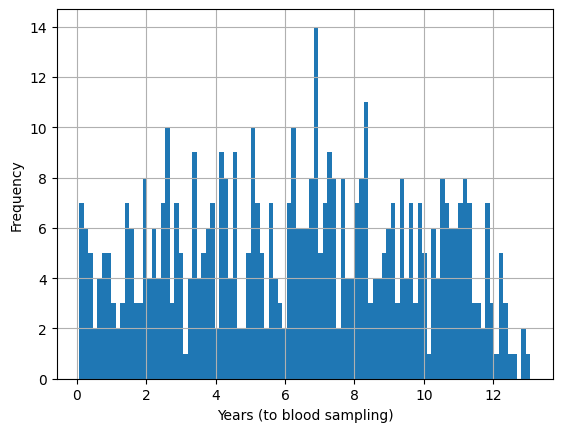

In [7]:
# Keep only L40 ICD codes
merged_pso = merged[merged['icd_code'].isin(pso_codes)]

# Convert ICD date to datetime
merged_pso['icd_date'] = pd.to_datetime(merged_pso['icd_date'], errors='coerce')

# Keep ICD dates strictly before 53-0.0
merged_prepso = merged_pso[merged_pso['icd_date'] <= merged_pso['53-0.0']]

# Substract the date between 53-0.0 and the ICD date, then plot to see the distribution
merged_prepso['delta'] = merged_prepso['53-0.0'] - merged_prepso['icd_date']
merged_prepso['delta'] = merged_prepso['delta'].dt.days / 365

# Create a histogram to check the distribution
ax = merged_prepso['delta'].hist(bins=100)
ax.set_xlabel('Years (to blood sampling)')
ax.set_ylabel('Frequency')

In [8]:
# Keep ICD dates within 1 year before 53-0.0
merged_prepso1y = merged_prepso[merged_prepso['delta'] <= 1]

# Extract the eid
eid_icd1y = merged_prepso1y['eid']
eid_icd1y_df = pd.DataFrame(eid_icd1y, columns=['eid'])

# Save the output
eid_icd1y.to_csv('eid_icd1y.tsv', sep='\t', index=False)

In [9]:
%%bash
dx upload "eid_icd1y.tsv"

ID                                file-J3jFPQ8JZ8jxvVqZKJp85y73
Class                             file
Project                           project-J0yb91QJZ8jZ9ppFk6zGQgGp
Folder                            /
Name                              eid_icd1y.tsv
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Thu Oct 16 09:15:45 2025
Created by                        agarham
 via the job                      job-J3jF1kjJZ8jbfpQJKy20z7f8
Last modified                     Thu Oct 16 09:15:45 2025
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"


## 2. Select GP prescription within 1 year to blood sampling

In [10]:
%%bash
dx download "UKB Metabolomics:/agarham/severity_gprecords.tsv"

In [11]:
# Import the datasets
gp_df = pd.read_csv('severity_gprecords.tsv', sep='\t')

# Merge the date of attendance to the dataframe
gp_df = pd.merge(part_df[['eid', '53-0.0']], gp_df, how='inner', on='eid')

# Convert dates to datetime
gp_df['53-0.0'] = pd.to_datetime(gp_df['53-0.0'], errors='coerce')
gp_df['issue_date'] = pd.to_datetime(gp_df['issue_date'], errors='coerce')

Text(0, 0.5, 'Frequency')

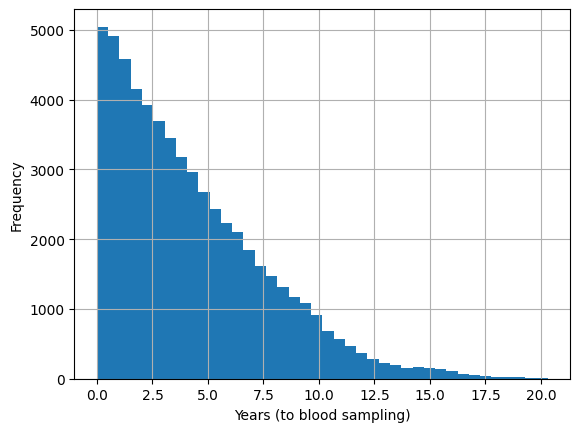

In [12]:
# Keep issue dates strictly before 53-0.0
gp_df = gp_df[gp_df['issue_date'] <= gp_df['53-0.0']]

# Substract the date between 53-0.0 and the issue date, then plot to see the distribution
gp_df['delta'] = gp_df['53-0.0'] - gp_df['issue_date']
gp_df['delta'] = gp_df['delta'].dt.days / 365

# Create a histogram to check the distribution
ax2 = gp_df['delta'].hist(bins=40)
ax2.set_xlabel('Years (to blood sampling)')
ax2.set_ylabel('Frequency')

In [14]:
# Keep issue dates within 1 year before 53-0.0
gp_df1y = gp_df[gp_df['delta'] <= 1]

# Extract the unique eid
eid_gp1y = gp_df1y['eid'].unique()
eid_gp1y = pd.DataFrame(eid_gp1y, columns=['eid'])

# Save the output
eid_gp1y.to_csv('eid_gp1y.tsv', sep='\t', index=False)

In [15]:
%%bash
dx upload "eid_gp1y.tsv"

ID                                file-J3jFPpjJZ8jbz3Fyb7P149bj
Class                             file
Project                           project-J0yb91QJZ8jZ9ppFk6zGQgGp
Folder                            /
Name                              eid_gp1y.tsv
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Thu Oct 16 09:16:27 2025
Created by                        agarham
 via the job                      job-J3jF1kjJZ8jbfpQJKy20z7f8
Last modified                     Thu Oct 16 09:16:27 2025
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"


## 3. Define severe psoriasis within 1 year, based on ICD, GP prescription records, and self-reported medications

In [16]:
# List of the self-reported medications
med_codes = [
    1140880090,
    1141188588,
    1140909844,
    1140910382,
    2038459888,
    1141201130,
    1141188594,
    1141195044,
    1140869978,
    1140869848,
    1140910036,
    1141167744,
    1140880092
]

# Get the columns starting with '20003-0.'
med_cols = [col for col in df.columns if col.startswith('20003-0.')]

# Check if any of the medication columns contain any of the codes in the list
med_df1y = df[df[med_cols].isin(med_codes).any(axis=1)]

# Extract the eid
eid_med1y = med_df1y['eid']
eid_med1y_df = pd.DataFrame(eid_med1y, columns=['eid'])

# Check the numbers
print(len(eid_med1y))

# Save the output
eid_med1y.to_csv('eid_med1y.tsv', sep='\t', index=False)

3317


In [17]:
# Check types
print(type(eid_icd1y))
print(type(eid_gp1y))
print(type(eid_med1y))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [18]:
# Turn into list
eid_icd1y = eid_icd1y.tolist() # eids of prevalent psoriasis with L40 ICD codes within 1 year
print(len(eid_icd1y))

eid_med1y = eid_med1y.tolist() # eids of prevalent psoriasis with L40 ICD codes within 1 year
print(len(eid_med1y))

eid_gp1y = eid_gp1y['eid'].tolist() # eids of prevalent psoriasis with GP prescribed psoriatic medications within 1 year
print(len(eid_gp1y))

# Combine the three lists and get the unique eids
eid_sev1y = list(set(eid_icd1y + eid_gp1y + eid_med1y))
print(len(eid_icd1y + eid_gp1y + eid_med1y))
print(len(eid_sev1y))

36
3317
1043
4396
3442


In [20]:
# Create a dataframe combining all lists, if eid is present in each of the lists
# Create new columns with 1 if it is present and 0 if not
df_sev1y = pd.DataFrame({'eid': part_df['eid']})

df_sev1y['icd1y'] = df_sev1y['eid'].isin(eid_icd1y).astype(int)
df_sev1y['gp1y'] = df_sev1y['eid'].isin(eid_gp1y).astype(int)
df_sev1y['med1y'] = df_sev1y['eid'].isin(eid_med1y).astype(int)
df_sev1y['sev1y'] = df_sev1y['eid'].isin(eid_sev1y).astype(int)

for col in ['icd1y', 'gp1y', 'med1y', 'sev1y']:
    print(f'{col} counts:')
    print(df_sev1y[col].value_counts())
    print()

icd1y counts:
icd1y
0    501930
1        36
Name: count, dtype: int64

gp1y counts:
gp1y
0    500923
1      1043
Name: count, dtype: int64

med1y counts:
med1y
0    498649
1      3317
Name: count, dtype: int64

sev1y counts:
sev1y
0    498524
1      3442
Name: count, dtype: int64



In [21]:
# Save the output
df_sev1y.to_csv('psoriasis_severity1y_icdgpmed.tsv', sep='\t', index=False)

In [22]:
%%bash
dx upload "psoriasis_severity1y_icdgpmed.tsv"

ID                                file-J3jFX90JZ8jVXV0J9vjjV5xB
Class                             file
Project                           project-J0yb91QJZ8jZ9ppFk6zGQgGp
Folder                            /
Name                              psoriasis_severity1y_icdgpmed.tsv
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Thu Oct 16 09:21:40 2025
Created by                        agarham
 via the job                      job-J3jF1kjJZ8jbfpQJKy20z7f8
Last modified                     Thu Oct 16 09:21:41 2025
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"
